In [1]:
using GLMNet
include("PSDiGraph.jl")
using .PSDiGraphs
include("dbn_preprocessing.jl")
using PyPlot
using CSV
include("dbn_distributions.jl")

logpdf (generic function with 18 methods)

In [2]:
timeseries_data_path = "data/mukherjee_data.csv"
protein_names_path = "data/protein_names.csv"
reference_adj_path = "data/prior_graph.csv"
timesteps_path = "data/time.csv"
hill_output = "data/edge_prob_matrix.csv"

"data/edge_prob_matrix.csv"

In [3]:
(timeseries_vec, protein_vec, ref_adj, timesteps) = hill_2012_preprocess(timeseries_data_path, 
                                                                         protein_names_path, 
                                                                         reference_adj_path, 
                                                                         timesteps_path);

output_probs = convert(Matrix{Float64}, CSV.read(hill_output));

In [4]:
Xminus, Xplus = combine_X(timeseries_vec)

([0.5304013 0.1122624 … 0.0184841 0.1667477; 0.719956 0.1307542 … 0.0451309 0.190425; … ; 1.5899875 0.2820151 … 0.1129844 0.1644564; 1.5271494 0.2952736 … 0.1127502 0.152335], [0.719956 0.1307542 … 0.0451309 0.190425; 0.7197007 0.1371308 … 0.0400143 0.1908446; … ; 1.5271494 0.2952736 … 0.1127502 0.152335; 0.9616714 0.2297056 … 0.1469264 0.1468985])

In [5]:
"""
Compute a vector of Bayesian Information Criterion values for a
GLMNet path.
"""
function compute_bic(ols_path, lasso_path, n::Int64, ols_df::Int64) 
    
    ols_ssr = (1.0 - ols_path.dev_ratio[1]) # *null deviation
    ssr_vec = (1.0 .- lasso_path.dev_ratio) # *null deviation
    df_vec = sum(lasso_path.betas .!= 0.0, dims=1)[1,:]
    
    bic_vec = ((n - ols_df).*ssr_vec./ols_ssr  .+  log(n).*df_vec) ./n # null deviations cancel out
    
    return bic_vec
end


"""
Use Adaptive LASSO (informed by prior knowledge of edge existence)
and a Bayesian Information Criterion to get a set of regression coefficients;
nonzero coefficients imply the existence of an edge in the MAP graph.
Note that we assume normally-distributed variables.
"""
function adalasso_edge_recovery(X::Matrix{Float64}, y::Vector{Float64}, prior_parents::Vector{Bool})
    
    n = size(y,1)
    yp = y .* n ./ (n+1)
    ols_result = GLMNet.glmnet(X, yp, lambda=[0.0])

    ada_weights = 1.0 .- prior_parents;
    adaptive_penalties = abs.(ada_weights ./ ols_result.betas)[:,1]
    
    lasso_path = GLMNet.glmnet(X, yp, penalty_factor=adaptive_penalties)
    
    bic_vec = compute_bic(ols_result, lasso_path, n, size(X,2))
    
    minloss_idx = argmin(bic_vec)
    
    return lasso_path.betas[:,minloss_idx], bic_vec, lasso_path

end


poly_lasso_edge_recovery

1 AKT.pS473


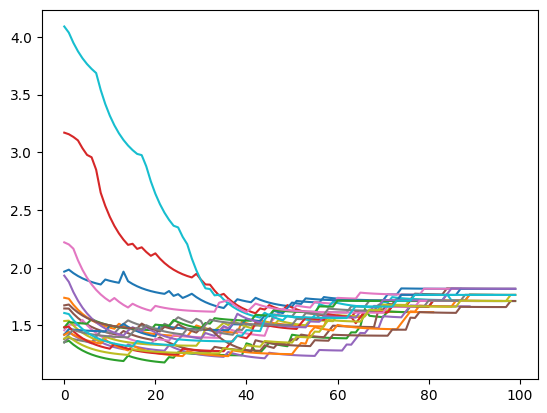

PRIOR PARENTS:		Bool[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
ESTIMATED PARENTS:	Bool[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0]
HILL PARENTS:		Bool[1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]

2 AKT.pT308
PRIOR PARENTS:		Bool[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
ESTIMATED PARENTS:	Bool[1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0]
HILL PARENTS:		Bool[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]

3 AMPK.PT172
PRIOR PARENTS:		Bool[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ESTIMATED PARENTS:	Bool[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]
HILL PARENTS:		Bool[1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1]

4 cJUN.pS73
PRIOR PARENTS:		Bool[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
ESTIMATED PARENTS:	Bool[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]
HILL PARENTS:		Bool[1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1

In [11]:
thresh = 0.01
poly_degree = 2
for y_ind=1:20

    y = Xplus[:,y_ind];
    prior_parents = ref_adj[y_ind];

    parents, bic, path = adalasso_edge_recovery(Xminus, y, prior_parents)
    plot(bic, label="BIC")
    #plot(ssr, label="SSR")
    #plot(df, label="df")
    
    hill_parents = (output_probs[:,y_ind] .>= thresh)
    println(y_ind, " ", protein_vec[y_ind])
    println("PRIOR PARENTS:\t\t", prior_parents, "\nESTIMATED PARENTS:\t", parents .!= 0.0, "\nHILL PARENTS:\t\t", hill_parents)
    println("")
end
show()